# Aprendizaje Automático para Series Temporales

### Aprendizaje Automático Intermedio e Ingeniería de Características

#### Febrero 2021

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

En este *notebook* vamos a practicar los fundamentos de Hidden Markov Models para caracterizar datos secuenciales con la implementación python del módulo [**hmmlearn** ](https://hmmlearn.readthedocs.io/en/latest/). Este módulo tiene un interfaz muy parecido a `sklearn`, pero necesita una instalación independiente.


In [3]:
# Para instalar hmmmlearn en colab
!pip install hmmlearn

In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from hmmlearn import hmm

# 1.- Introducción a datos secuenciales

Hasta ahora en el curso nos hemos centrado en datos i.i.d (independientes e idénticamente distribuidos):

- Los conjuntos de datos están formados por observaciones que tienen el mismo número de características
- Hemos aplicado transformaciones a cada dato individual o a cada característica:
    - escalados, normalizaciones
    - Selección de características, extracción de características
- Hemos aprendido modelos capaces de hacer inferencia para datos individuales:
    - Predecir la clase de cada dato
    - Predecir el valor de un *score* para cada dato (regresión)
    - Decidir si un dato es *outlier*
    
- En general asumimos que los datos salen de una distribución con estadísticos estacionarios (o que cambian muy muy despacio) y que da igual el orden en el que saquemos los datos para aprender el modelo, ya que el modelo se aplicará sobre datos individuales.

- En algunos otros escenarios de aplicación la información relevante para construir el modelo y hacer inferencia no está contenida en cada dato individual, sino en la **secuencia que forman estos datos**, es decir, **el orden importa**.
    - Entonces el objeto sobre el que construiremos los modelos y haremos la inferencia es la secuencia: **un conjunto de observaciones ordenadas**.
    - Asumiremos que las **dinámicas subyacentes** a la secuenciación de observaciones **son estacionarias**, o que cambian muy muy lentamente.

## Ejemplo: el orden importa



In [5]:
from IPython.display import Audio
from scipy.io import wavfile

Cargamos un fichero con una serie temporal

In [6]:
samplerate, x = wavfile.read('imperial.wav')

Representamos gráficamente algunas observaciones. Cada observación es un escalar (1D)

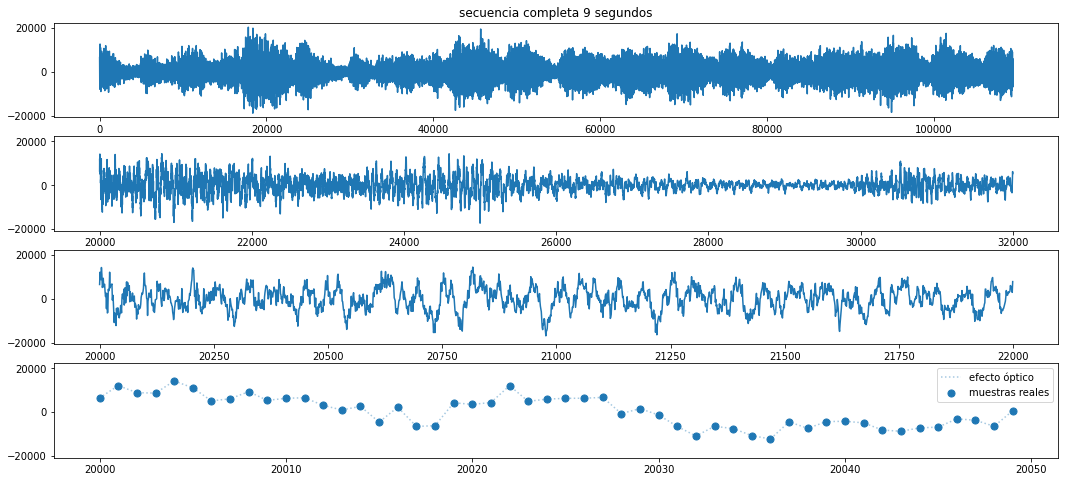

In [7]:
ff,aa = plt.subplots(4,1,figsize=(18,8), sharey=True)
aa[0].plot(x)
aa[0].set_title('secuencia completa 9 segundos')
aa[1].plot(range(20000,32000),x[20000:32000])
aa[2].plot(range(20000,22000),x[20000:22000])
aa[3].scatter(range(20000,20050),x[20000:20050],marker='o',s=50,label='muestras reales')
aa[3].plot(range(20000,20050),x[20000:20050],linestyle=':',alpha=0.4,label='efecto óptico')
aa[3].legend()

El fichero contiene una señal de audio, la podemos escuchar

In [8]:
Audio(x, rate=samplerate )

Para ver que el orden de las observaciones es importante, vamos a hacer **permutaciones de bloques** y a escuchar el resultado

In [9]:
# permutation of x, blockwise
def block_permutation(x, nblocks):

    block_start = np.linspace(0,len(x),nblocks+1,dtype=int)
    block_end = block_start[1:]
    block_start = block_start[:-1]
   
    block_permutation = np.random.permutation(nblocks)
    x_block_permutation = x[block_start[block_permutation[0]]:block_end[block_permutation[0]]]
    for bb in range(1,nblocks):
        x_block_permutation = np.hstack((x_block_permutation, 
                                     x[block_start[block_permutation[bb]]:block_end[block_permutation[bb]]]))  
    return x_block_permutation

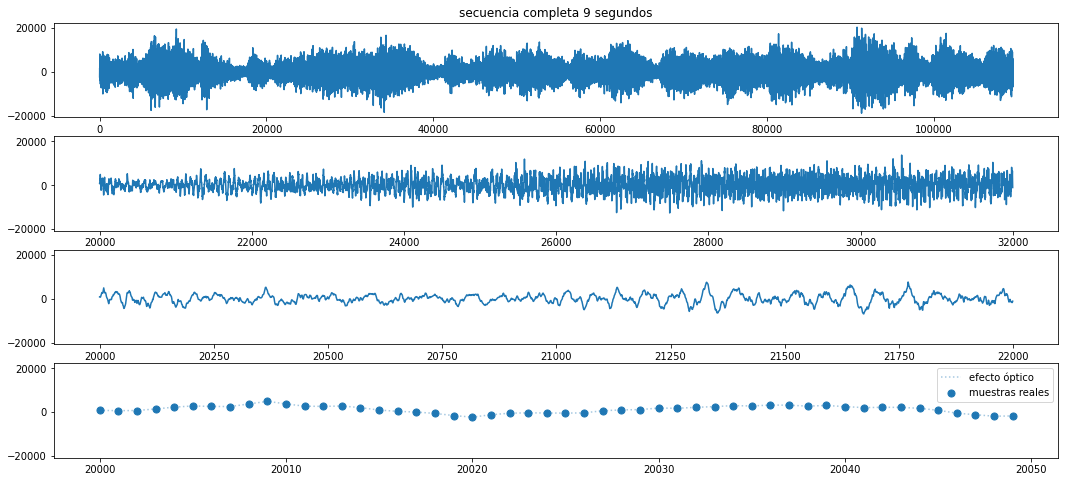

In [10]:
x_block_permutation = block_permutation(x, nblocks=9)
ff,aa = plt.subplots(4,1,figsize=(18,8), sharey=True)
aa[0].plot(x_block_permutation)
aa[0].set_title('secuencia completa 9 segundos')
aa[1].plot(range(20000,32000),x_block_permutation[20000:32000])
aa[2].plot(range(20000,22000),x_block_permutation[20000:22000])
aa[3].scatter(range(20000,20050),x_block_permutation[20000:20050],marker='o',s=50,label='muestras reales')
aa[3].plot(range(20000,20050),x_block_permutation[20000:20050],linestyle=':',alpha=0.4,label='efecto óptico')
aa[3].legend()

In [11]:
Audio(x_block_permutation, rate=samplerate )

Si la permutación es más agresiva, por ejemplo dividimos la señal en 10000 bloques y los permutamos, perdemos gran parte de la información. Ojo, no hemos perdido las observaciones, sólo las hemos descolocado...

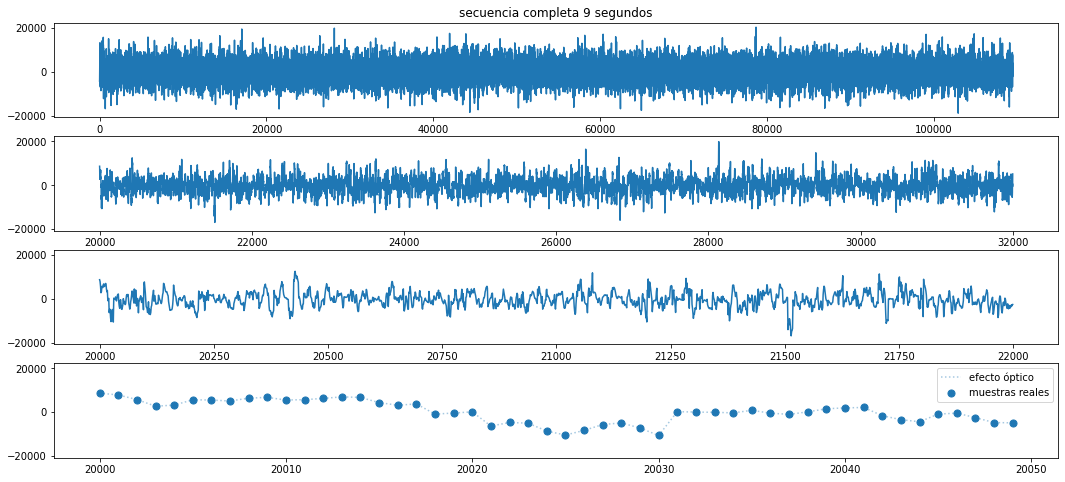

In [12]:
x_block_permutation = block_permutation(x, nblocks=10000)
ff,aa = plt.subplots(4,1,figsize=(18,8), sharey=True)
aa[0].plot(x_block_permutation)
aa[0].set_title('secuencia completa 9 segundos')
aa[1].plot(range(20000,32000),x_block_permutation[20000:32000])
aa[2].plot(range(20000,22000),x_block_permutation[20000:22000])
aa[3].scatter(range(20000,20050),x_block_permutation[20000:20050],marker='o',s=50,label='muestras reales')
aa[3].plot(range(20000,20050),x_block_permutation[20000:20050],linestyle=':',alpha=0.4,label='efecto óptico')
aa[3].legend()

In [13]:
Audio(x_block_permutation, rate=samplerate )

## Aplicaciones del procesamiento de secuencias:

- Multimedia
    - Segmentación de audio, vídeo, conversaciones
    - Conversiones voz-texto y texto-voz
    - Reconocimiento de canciones
- Biosanitarias
    - Resonancias magnéticas funcionales
    - Electrocardiogramas
    - Electroencefalogramas
- Finanzas
    - Caracterización de regímenes de mercados
    - Indicadores para algoritmos de *trading*

# 2.- Modelos Ocultos de Markov (*Hidden Markov Models*)

Es un método para modelar secuencias discretas. Es decir, en cada instante de tiempo (y no se especifica el intervalo entre instantes de tiempo) se genera un elemento nuevo de la secuencia, desde el primer elemento que se **emite** en $t=0$ hasta el último elemento que se emite en $t=T-1$. Por tanto tenemos una secuencia de $T$ elementos. En principio **no asumimos que todas las secuencias tienen la misma longitud**.

## 2.1.- Sistema de Markov (observado)

Un sistema de Markov es un **modelo generativo** que podemos emplear para crear una secuencia de $T$ elementos de un **diccionario discreto**.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/hmm1.png' width=10000 />


El sistema tiene los siguientes elementos:
- **Estados** $\{S_1, S_2, S_3\}$, son los elementos del diccionario
- **Probabilidades iniciales** $\{\pi_1, \pi_2, \pi_3\}$
- **Probabilidades de transición** $p_{ij}=p(q_t=S_j|q_{t-1}=S_i)$ 



<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/hmm1.png' width=10000 />

**Algoritmo para generar secuencias con el modelo**

1. Elegir un estado inicial $q_0$ con probabilidades $\{\pi_1, \pi_2, \pi_3\}$

2. Iterar para $t=1,\dots,T-1$
    - Elegir el estado $q_t$ a partir de $q_{t-1}$ y las probabilidades de transición 
    
3. Ejemplo de salida: $[S_1, S_2, S_2, S_3, S_1, S_1, S_3, S_2]$

**Propiedad de Markov**

Cada estado de la cadena depende sólo del estado en el instante anterior.
$$
p(q_t=S_j|q_{t-1}=S_i, q_{t-2}= S_k,...,q_0=S_n) \\ =p(q_t=S_j|q_{t-1}=S_i)
$$


#### Averiguar estados

La pregunta típica que queremos  contestar cuando exploramos un sistema de Markov es averiguar la probabilidad de acabar en un cierto estado $S_j$ si empezamos en $q_0=S_i$ después de $T$ iteraciones:
$$
p(q_T=S_j)
$$

La respuesta **lenta e ineficiente**:
1. Encontrar todas las trayectorias que empiezan en $q_0=S_i$ y acaban en $q_T=S_j$
$$
Q=\{q_0=S_i,q_1,q_2,\dots,q_{t-1},q_T=S_j\}
$$
2. Calcular la probabilidad de cada trayectoria
$$
\begin{array}{lcl}p(Q) &=& p(q_0, q_1, q_2, ...,q_T=S_j)\\
&=& p(q_0, q_1, q_2, ...,q_{T-1})p(q_T|q_0, q_1, q_2, ...,q_{T-1}) \\
&=& p(q_0, q_1, q_2, ...,q_{T-1})p(q_T|q_{T-1}) \\
&=& p(q_0, q_1, q_2, ...,q_{T-2})p(q_T|q_{T-1})p(q_{T-1}|q_{T-2}) \\
&\cdots & \\
&=&  p(q_T|q_{T-1})p(q_{T-1}|q_{T-2}) \dots p(q_2|q_1)p(q_1|q_0)\pi_0
\end{array}
$$
3. Combinar todas las trayectorias
$$
p(q_t = S_j) =\sum_{\mbox{trayectorias $Q$ que acaban en }S_j} p(Q)
$$

### Programación dinámica

La respuesta eficiente al problema de averiguar los estados es la **programación dinámica**.

Para cada estado $S_j$ se calcula la probabilidad de llegar a él en la iteración $t$
$$
p_t(j) = p(q_t=S_j)
$$

A continuación se aplica un **algoritmo inductivo** que puede calcularse con $O(TN^2)$ (el ineficiente cuesta $O(N^T)$)

1. Iteración inicial

$$
p_0(j)= \left\{ \begin{array}{ll} 1 & \mbox{si  $S_j$  es el estado inicial} \\ 0 & \mbox{ en cualquier otro caso} \end{array}\right.
$$

2. Resto de iteraciones

$$
\begin{array}{lcl}
p_t(j) &=& \sum_{i=1}^N{p(q_t=S_j, q_{t-1}=S_i)} \\ 
 &=& \sum_{i=1}^N{p(q_t=S_j|q_{t-1}=S_i)p_{t-1}(i)}\\
&=& \sum_{i=1}^N{A_{ij}p_{t-1}(i)}\\
\end{array}
$$ 

donde $N$ es el número de estados y $A$ es una matriz $N\times N$ que almacena las **probabilidades de transición**. En este modelo las probabilidades de transición son estacionarias.

#### Ejemplo con 3 estados

$$
A= \left [\begin{array}{ccc} a_{11} & a_{12} & a_{13}\\ a_{21} & a_{22} & a_{23}\\ a_{31} & a_{32} & a_{33} \end{array} \right ] = \\ \left [ \begin{array}{ccc} p(q_t=S_1|q_{t-1}=S_1) & p(q_t=S_2|q_{t-1}=S_1) & p(q_t=S_3|q_{t-1}=S_1)\\ p(q_t=S_1|q_{t-1}=S_2) & p(q_t=S_2|q_{t-1}=S_2) & p(q_t=S_3|q_{t-1}=S_2)\\  \color{red}{p(q_t=S_1|q_{t-1}=S_3)} & \color{red}{p(q_t=S_2|q_{t-1}=S_3)} & \color{red}{p(q_t=S_3|q_{t-1}=S_3)} \end{array} \right ]
$$

En rojo tenemos las transiciones desde el estado $S_3$

Supongamos  que el estado inicial es $S_3$. Entonces las probabilidades de cada estado en la iteración $t=1$ serán:

$$
\left [ \begin{array}{c} p_{1}(1) \\p_{1}(2) \\p_{1}(3) \end{array} \right ] = \left [\begin{array}{c} p(q_1=S_1|q_0=S_3)\\ p(q_1=S_2|q_0=S_3) \\ p(q_1=S_3|q_0=S_3) \end{array} \right ] = A^\top \left [ \begin{array}{c} 0 \\ 0 \\ 1 \end{array} \right ] 
$$

Es decir, el producto de la matriz de probabilidades de transición $A$ por un vector con las probabilidades de estado actuales. Como **sabemos** que empezamos en el estado $S_3$, este vector es el $[0, 0, 1]^\top$.

Si expresamos nuestra **incertidumbre** acerca de cuál es el estado inicial mediante un vector de probabilidades de estado inicial 
$$
\left [ \begin{array}{c} p_0(1) \\p_0(2) \\p_0(3) \end{array} \right ]
$$
entonces, en genérico
$$
\left [ \begin{array}{c} p_{1}(1) \\p_{1}(2) \\p_{1}(3) \end{array} \right ]  = A^\top  \left [ \begin{array}{c} p_0(1) \\p_0(2) \\p_0(3) \end{array} \right ]
$$

A partir de las probabilidades de estado en la iteración $t=1$ podemos calcular las probabilidades de estado en $t=2$

$$
\left [ \begin{array}{c} p_2(1) \\p_2(2) \\p_2(3) \end{array} \right ] =  A^\top \left [ \begin{array}{c} p_1(1) \\p_1(2) \\p_1(3) \end{array} \right ] = (A^\top) ^2 \left [ \begin{array}{c} p_0(1) \\p_0(2) \\p_0(3) \end{array} \right ] 
$$

Y así sucesivamente
$$
\left [ \begin{array}{c} p_T(1) \\p_T(2) \\p_T(3) \end{array} \right ] =  A^\top \left [ \begin{array}{c} p_{T-1}(1) \\p_{T-1}(2) \\p_{T-1}(3) \end{array} \right ] = (A^\top)^2 \left [ \begin{array}{c} p_{T-2}(1) \\p_{T-2}(2) \\p_{T-2}(3) \end{array} \right ] =\cdots =(A^\top) ^T \left [ \begin{array}{c} p_0(1) \\p_0(2) \\p_0(3) \end{array} \right ] 
$$

### Ejemplo con código

Definimos el modelo

In [52]:
Estados = ['Cero ','Uno ', 'Dos ']
P_iniciales = np.array([0.2, 0.3, 0.5])
P_transicion = np.array([[0.8, 0.1, 0.1],[0.2,0.5,0.3],[0.1, 0.2, 0.7]])


Generamos una secuencia de $T$ elementos

In [57]:
T=10
secuencia_estados = []

estado_inicial = np.random.rand(1)
if estado_inicial < P_iniciales[0]:
    estado_actual = 0
elif estado_inicial < P_iniciales[0] + P_iniciales[1]:
    estado_actual = 1
else:
    estado_actual = 2
secuencia_estados.append(Estados[estado_actual])   
print(secuencia_estados)

['Uno ']


In [58]:
for t in range(1,T):
    siguiente_estado = np.random.rand(1)
    if siguiente_estado < P_transicion[estado_actual, 0]:
        estado_actual = 0
    elif siguiente_estado < P_transicion[estado_actual, 0] + P_transicion[estado_actual, 1]:
        estado_actual = 1
    else:
        estado_actual = 2
    secuencia_estados.append(Estados[estado_actual])  
    print(secuencia_estados)

['Uno ', 'Uno ']
['Uno ', 'Uno ', 'Uno ']
['Uno ', 'Uno ', 'Uno ', 'Uno ']
['Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ']
['Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Dos ']
['Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Dos ', 'Uno ']
['Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Dos ', 'Uno ', 'Dos ']
['Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Dos ', 'Uno ', 'Dos ', 'Uno ']
['Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Dos ', 'Uno ', 'Dos ', 'Uno ', 'Cero ']


In [59]:
print(secuencia_estados)

['Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Dos ', 'Uno ', 'Dos ', 'Uno ', 'Cero ']


Generamos un conjunto de secuencias de estados

In [60]:
def genera_secuencia(T):
    secuencia_estados = []
    estado_inicial = np.random.rand(1)
    if estado_inicial < P_iniciales[0]:
        estado_actual = 0
    elif estado_inicial < P_iniciales[0] + P_iniciales[1]:
        estado_actual = 1
    else:
        estado_actual = 2
    secuencia_estados.append(Estados[estado_actual]) 
    for t in range(1,T):
        siguiente_estado = np.random.rand(1)
        if siguiente_estado < P_transicion[estado_actual, 0]:
            estado_actual = 0
        elif siguiente_estado < P_transicion[estado_actual, 0] + P_transicion[estado_actual, 1]:
            estado_actual = 1
        else:
            estado_actual = 2
        secuencia_estados.append(Estados[estado_actual])   
    return secuencia_estados

In [63]:
Nq = 6
Q = []
for Q in range(Nq):
    T = np.random.randint(6,12)
    print(genera_secuencia(T))

['Uno ', 'Cero ', 'Cero ', 'Cero ', 'Cero ', 'Dos ', 'Cero ', 'Cero ', 'Cero ', 'Cero ', 'Cero ']
['Cero ', 'Cero ', 'Cero ', 'Uno ', 'Dos ', 'Dos ', 'Uno ', 'Dos ', 'Dos ', 'Dos ']
['Uno ', 'Dos ', 'Dos ', 'Dos ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ', 'Uno ']
['Dos ', 'Uno ', 'Dos ', 'Dos ', 'Dos ', 'Dos ', 'Dos ']
['Dos ', 'Dos ', 'Uno ', 'Uno ', 'Uno ', 'Dos ']
['Dos ', 'Dos ', 'Uno ', 'Uno ', 'Uno ', 'Cero ', 'Cero ', 'Cero ', 'Cero ', 'Cero ']


## 2.2.- Modelo Oculto de Markov

Un Modelo Oculto de Markov (*Hidden Markov Model*, HMM) es otro modelo **generativo** para construir secuencias, más sofisticado que el sistema de Markov pues añade las **densidades de probabilidad de emisión**.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/hmm2.png' width=10000 />

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/hmm2.png' width=10000 />

**Elementos**

- **Estados** $\{S_1, S_2, S_3\}$, en un HMM los estados **no son observables**, son variables latentes
- **Probabilidades iniciales** $\{\pi_1, \pi_2, \pi_3\}$
- **Probabilidades de transición** $p_{ij}=p(q_t=S_j|q_{t-1}=S_i)$ 

- **Probabilidades de emisión** 
$f_j(o_t) = p(\mathbf x_t|q_t=S_j)$ función de densidad de probabilidad que genera las observaciones cuando el modelo está en el estado $S_j$. Por ejemplo una Gaussiana $\mathbf x_t \sim \mathcal N(\mathbf m_j, \Sigma_j)$
- **observaciones** $o_t = \mathbf x_t$ son los elementos que forman la secuencia que observamos en realidad. Asumimos que las observaciones se generan con las probabilidades de emisión. 

### Algoritmo para generar secuencias de observaciones

1. Inicio
    - Elegir un estado inicial $q_0$ con probabilidades $\{\pi_1, \pi_2, \pi_3\}$
    - Muestrear la observación $o_0$ de la **densidad de probabilidad de emisión** correspondiente al estado $q_0$:
    $o_0 = \mathbf x_0 \sim f_j(\mathbf x)$ donde $S_j=q_0$
2. Iterar para $t=1,\dots,T$
    - Elegir el estado $q_t$ a partir de $q_{t-1}$ y las probabilidades de transición 
    - Muestrear la observación de la **densidad de probabilidad de emisión** correspondiente al estado $q_t$:
    $o_t = \mathbf x_t \sim f_j(\mathbf x)$
3. Ejemplo de salida: $[\mathbf x_0,\mathbf x_1, \mathbf x_2, \mathbf x_3, \dots, \mathbf x_T]$

A diferencia del sistema de Markov, ahora las observaciones que componen la secuencia pueden ser vectores en un espacio de $p$ dimensiones $\mathbf x_t \in \mathbb R^p$

**Propiedad de Markov**

Sigue valiendo con los HMM: Cada **estado** de la cadena depende sólo del **estado en el instante anterior**.
$$
p(q_t=S_j|q_{t-1}=S_i, q_{t-2}= S_k,...,q_0=S_n) \\ =p(q_t=S_j|q_{t-1}=S_i)
$$

En un HMM se distingue entre **observaciones** $o_t = \mathbf x_t$ y **estados** $q_t = S_i$. Los estados son **variables latentes** (no se observan).

Cada observación $o_t$ **depende exclusivamente del estado** $q_t$. Las observaciones son **condicionalmente independientes** dados los estados

$$
p(o_t=\mathbf x_t, |q_t=S_j, o_{t-1}=\mathbf x_{t-1}, q_{t-1}=S_i, ...,o_0=\mathbf x_0,q_0=S_n) \\ =p(o_t=\mathbf x_t, |q_t=S_j)
$$

### Ejemplo con código, continuación

In [68]:
Estados = ['Par','Primo', 'Multiplo3']
P_iniciales = np.array([0.2, 0.3, 0.5])
P_transicion = np.array([[0.8, 0.1, 0.1],[0.2,0.5,0.3],[0.1, 0.2, 0.7]])


In [69]:
data = np.loadtxt("mnist_test.csv", 
                       delimiter=",") 
fac = 0.99 / 255
X=np.asfarray(data[:, 1:]) * fac + 0.01
Y = np.array([int(cc) for cc in data[:, :1]])
print("Cargados {0:d} dígitos".format(X.shape[0]))
print("")
for cc in range(10):
    print("El dígito {0:d} tiene {1:d} ejemplos".format(cc,np.sum(Y==cc)))
Emisiones = {'Par':[],
            'Primo':[],
            'Multiplo3':[]}
for cc in range(10):
    if cc % 2 == 0:
        Emisiones['Par'] += (np.where(Y==cc)[0][:800]).tolist()
    if cc % 3 == 0:
        Emisiones['Multiplo3'] += (np.where(Y==cc)[0][:800]).tolist()
    if (cc==1) or (cc==2) or (cc==3) or (cc==5) or (cc==7):
        Emisiones['Primo'] += (np.where(Y==cc)[0][:800]).tolist()

Multinomiales = {k:np.zeros(len(Y)) for k,v in Emisiones.items()}
for k in Multinomiales:
    Multinomiales[k][Emisiones[k]] = 1./len(Emisiones[k])

Cargados 10000 dígitos

El dígito 0 tiene 980 ejemplos
El dígito 1 tiene 1135 ejemplos
El dígito 2 tiene 1032 ejemplos
El dígito 3 tiene 1010 ejemplos
El dígito 4 tiene 982 ejemplos
El dígito 5 tiene 892 ejemplos
El dígito 6 tiene 958 ejemplos
El dígito 7 tiene 1028 ejemplos
El dígito 8 tiene 974 ejemplos
El dígito 9 tiene 1009 ejemplos


Representamos gráficamente algunos ejemplos.

- Múltiplos de 3

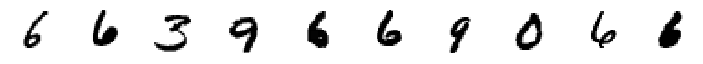

In [70]:
nrows = 1
ncols = 10
ff,aa = plt.subplots(nrows, ncols,figsize=(10,1))
ii = 0
for cc in range(ncols):
    aa[cc].set_axis_off()
    ii = np.random.randint(0,len(Emisiones['Multiplo3']))
    aa[cc].imshow(X[Emisiones['Multiplo3'][ii]].reshape(28,28), 
                      cmap=plt.cm.gray_r, 
                      interpolation='nearest')
ff.tight_layout()  



- Números pares

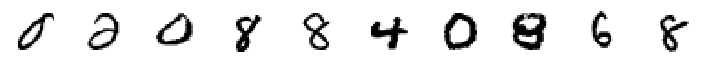

In [71]:
nrows = 1
ncols = 10
ff,aa = plt.subplots(nrows, ncols,figsize=(10,1))
ii = 0
for cc in range(ncols):
    aa[cc].set_axis_off()
    ii = np.random.randint(0,len(Emisiones['Par']))
    aa[cc].imshow(X[Emisiones['Par'][ii]].reshape(28,28), 
                      cmap=plt.cm.gray_r, 
                      interpolation='nearest')
ff.tight_layout()  

  

Números primos

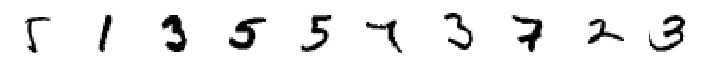

In [72]:
nrows = 1
ncols = 10
ff,aa = plt.subplots(nrows, ncols,figsize=(10,1))
ii = 0
for cc in range(ncols):
    aa[cc].set_axis_off()
    ii = np.random.randint(0,len(Emisiones['Primo']))
    aa[cc].imshow(X[Emisiones['Primo'][ii]].reshape(28,28), 
                      cmap=plt.cm.gray_r, 
                      interpolation='nearest')
ff.tight_layout()

Aprendemos la secuencia. Las probabilidades de emisión son multinomiales:
- `Primos`: la probabilidad de cada imagen es 0 si el dígito no es primo y $1/N_1$ si el dígito es un número primo, donde $N_1$ es el total de ejemplos de imágenes de números primos en el dataset

- `Pares`: la probabilidad de cada imagen es 0 si el dígito no es par y $1/N_2$ si el dígito es un número par, donde $N_2$ es el total de ejemplos de imágenes de números pares en el dataset

- `Múltiplo de 3`: la probabilidad de cada imagen es 0 si el dígito no es múltiplo de 3 y $1/N_3$ si el dígito es un número múltiplo de 3, donde $N_3$ es el total de ejemplos de imagen de números múltiplos de 3 en el dataset

In [76]:
T=10
secuencia_estados = []
secuencia_observaciones = np.empty((T,28*28))
estado_inicial = np.random.rand(1)
if estado_inicial < P_iniciales[0]:
    estado_actual = 0
elif estado_inicial < P_iniciales[0] + P_iniciales[1]:
    estado_actual = 1
else:
    estado_actual = 2
secuencia_estados.append(Estados[estado_actual])  

ii = np.argmax(np.random.multinomial(1,Multinomiales[Estados[estado_actual]].tolist()))
secuencia_observaciones[0,:] = X[ii]
for t in range(1,T):
    siguiente_estado = np.random.rand(1)
    if siguiente_estado < P_transicion[estado_actual, 0]:
        estado_actual = 0
    elif siguiente_estado < P_transicion[estado_actual, 0] + P_transicion[estado_actual, 1]:
        estado_actual = 1
    else:
        estado_actual = 2
    secuencia_estados.append(Estados[estado_actual])   
    
    ii = np.argmax(np.random.multinomial(1,Multinomiales[Estados[estado_actual]].tolist()))
    secuencia_observaciones[t,:] = X[ii]

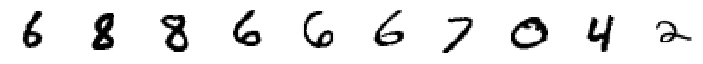

In [77]:
nrows = 1
ncols = T
ff,aa = plt.subplots(nrows, ncols,figsize=(T,1))
ii = 0
for cc in range(ncols):
    aa[cc].set_axis_off()
    aa[cc].imshow(secuencia_observaciones[cc].reshape(28,28), 
                      cmap=plt.cm.gray_r, 
                      interpolation='nearest')
    #aa[cc].set_title(secuencia_estados[cc])
ff.tight_layout()  

Imprimimos también el estado. No es observable, pero vemos cómo hay ejemplos donde estados diferentes generan observaciones parecidas.

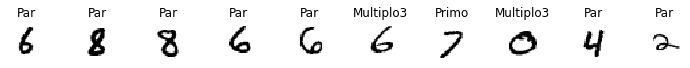

In [78]:
nrows = 1
ncols = T
ff,aa = plt.subplots(nrows, ncols,figsize=(T,1))
ii = 0
for cc in range(ncols):
    aa[cc].set_axis_off()
    aa[cc].imshow(secuencia_observaciones[cc].reshape(28,28), 
                      cmap=plt.cm.gray_r, 
                      interpolation='nearest')
    aa[cc].set_title(secuencia_estados[cc])
ff.tight_layout()  

### Operaciones básicas con modelos ocultos de Markov

- **Estimación del estado actual** $p(q_T=S_j|o_0,\dots,o_T)$

 - Se resuelve mediante el algoritmo *forward-backward*
- **Encontrar la trayectoria de estados más probable para una secuencia de observaciones**
    - Dadas $\{o_0,o_1,\dots,o_T\}$, ¿cuál es la secuencia de estados más probable que haya generado la secuencia de observaciones?
    - Se resuelve mediante el **algoritmo de Viterbi**
- **Aprendizaje del HMM**
    - Dadas $\{o_0,o_1,\dots,o_T\}$, encontrar los parámetros del modelo que ha generado esta secuencia con mayor probabilidad
    - Se resuelve mediante el **algoritmo E-M** *Expectation-Maximization* (el algoritmo E-M ya lo hemos revisado para el *Gaussian Mixture Model*, GMM).

## Estimación de estados en HMMs: algoritmo *Forward-Backward*

El problema de estimación de estados se define como:

Dada una secuencia de observaciones $\{o_0,o_1,\dots,o_T\}$, **¿Cuál es la probabilidad de que el estado $q_t$ sea $S_j$?**

Este problema se resuelve en dos partes, la *forward* y la *backward*

### Parte *forward*

Para resolver este problema necesitamos definir unas variables auxiliares $\alpha_t(j)$, $t=0,\dots,T-1$, $j=1,\dots,N$ donde $T$ es la longitud de la secuencia y $N$ el número de estados:
$$
\alpha_t(j) = p(o_0,o_1,\dots,o_t, q_t=S_j)
$$
es decir, $\alpha_t(j)$ es la probabilidad de haber observado las $t+1$ observaciones desde $t=0$ hasta $t$ y que el estado en el instante $t$ sea $S_j$. 

Estas variables se aprenden por **inducción**
1. **Inicialización**
$$
\alpha_{t=0}(j) = \pi_jf_j(o_0), \quad j=1,\dots,N
$$

donde $f_j()$ es la densidad de probabilidad de emisión que genera las observaciones cuando el modelo está en el estado $S_j$. En este escenario asumimos que las $N$ $f_j()$ son conocidas

2. **Inducción**
$$
\alpha_t(j) = \left ( \sum_{i=1}^N{\alpha_{t-1}(i)A_{ij}}\right )f_j(o_t), \quad j=1,\dots, N, \quad t=1,\dots,T-1 
$$

Para pasar al estado $S_j$ en el instante $t$, tengo que sumar todas las opciones que tengo de pasar a $S_j$ desde cualquier estado $S_i$ en el que esté en el instante $t-1$. Además multiplico por la probabilidad de observar $o_t$ saliendo del estado $S_j$ en el instante $t$.

3. **Fin**
$$
p(o_0, o_1,\dots,o_{T-1}) =\sum_{j=1}^N\alpha_{T-1}(j) 
$$

La probabilidad de que las observaciones hayan salido del modelo es la suma de todas las $\alpha_t(j)$ en el instante final $t=T-1$



### Parte *backward*

Análogamente definimos las variables auxiliares $\beta_t(j)$ como la probabilidad de estar en el estado $S_j$ en el instante $t$ y además observar las observaciones que van desde $o_t$ hasta el final de la secuencia ($o_T$).

$$
\beta_t(j) = p(o_{t+1},o_{t+2},\dots,o_T,q_t=S_j), \quad t=0,\dots,T-1, \quad j=1,\dots,N 
$$

Las variables $\beta_t(j)$ también se aprenden por inducción

1. **Inicialización**
$$
\beta_{T-1}(j) = 1, \quad j=1,\dots,N
$$

Independientemente de en qué estado acabemos (en el instante $T-1$), hemos acabado la secuencia con probabilidad 1.

2. **Inducción**

$$
\beta_t(j) = \left ( \sum_{i=1}^N{\beta_{t+1}(i)A_{\color{red}{ji}}}f_i(o_{t+1})\right ), \quad j=1,\dots, N, \quad t=T-2,\dots,0 
$$

Desde el estado $S_j$ en el instante $t$ habremos saltado a cualquiera de los $N$ estados posibles $S_i$ en el instante $t+1$ y observado $o_{t+1}$, tal y como recoge el término de la suma.


### Solución

La respuesta a cuál es el estado más probable $S_j$ en el instante $t$ dada la secuencia de observaciones se calcula viendo el estado $S_j$ que maximiza
la probabilidad de
1. observar las observaciones $o_0$ a $o_{t-1}$
2. y saltar al estado $S_j$ instante $t$
3. y que la observación $o_t$ sea generada en el instante $t$ por el estado $S_j$
4. y observar las observaciones $o_{t+1}$ a $o_{T-1}$

Los 3 primeros puntos los recoge $\alpha_t(j)$; el punto 4 lo recoge $\beta_t(j)$ por tanto la probabilidad que buscamos maximizar es

$$
p(o_0,o_1,\dots,o_t, q_t=S_j)p(q_t=S_j,o_{t+1},o_{t+2},\dots,o_T) = \alpha_t(j)\beta_t(j)
$$

## Estimación de la secuencia más probable de estados

Dada una secuencia de observaciones, encontrar la **secuencia de estados que mejor explica la generación de esta secuencia** en el sentido de que se maximice la probabilidad de que estos estados sean los que han generado las observaciones.

Una primera aproximación puede ser devolver el **conjunto de estados individualmente más probables**. Definimos las variables $\gamma_t(i)$ como la probabilidad de estar en el estado $S_i$ en el instante $t$ condicionada a que hemos observado toda la secuencia:

$$
\gamma_t(i) = p(q_t = S_i|o_0, o_1,\dots,o_{T-1}), \quad i=1,\dots,N
$$

Las variables $\gamma_t(i)$ se pueden calcular fácilmente a partir de las $\alpha_t(j)$  y $\beta_t(j)$: Las variables $\alpha_t(j)$ almacenan la información relevante desde el inicio de la secuencia hasta el instante $t$ inclusive, y las variables $\beta_t(j)$ almacenan la información desde el instante $t$ hasta el final de la secuencia. Por tanto

$$
\gamma_t(i) = p(q_t = S_i|o_0, o_1,\dots,o_{T-1}) = \frac{p(o_0, o_1,\dots,o_{T-1},q_t = S_i)}{p(o_0, o_1,\dots,o_{T-1})} =\frac{\alpha_t(i)\beta_t(i)}{p(o_0, o_1,\dots,o_{T-1})} 
$$

$$
= \frac{\alpha_t(i) \beta_t(i)}{\sum_{j=1}^N{\alpha_t(j) \beta_t(j)}}, \quad i=1,\dots, N,\quad t=0,\dots,T-1
$$

El estado más probable responsable de la **generación de cada observación** de la cadena puede obtenerse como 

$$
q_t=S_i \mbox{ tal que } S_i = \mbox{argmax}_{i=1,\dots,N} \gamma_t(i) \quad t=0,\dots,T-1
$$

### Algoritmo de Viterbi

Hay una respuesta más exacta a obtener la secuencia de estados que es **optimizar la secuencia completa**, no devolver el estado más probable para cada observación. 

Para resolver este problema necesitamos definir dos juegos de variables auxiliares $\delta_t(j)$ y $\psi_t(j)$. Las variables $\delta_t(j)$ llevan cuenta de la máxima probabilidad de haber generado la secuencia observada hasta el instante $t$ con el modelo (esto es, habiendo usado la cadena de estados más probable hasta el instante $t$, y pasando por el estado $S_j$ en el instante $t$). Las variables $\psi_t(j)=i$ quiere decir que el estado más probable en  el instante $t-1$ desde el que saltaríamos al estado $S_j$ en el instante $t$ es $S_i$ .

$$
\delta_t(j) = \max_{q_0,q_1,\dots, q_{t-1}}p(q_0,q_1,\dots,q_{t-1},q_t=S_j, o_0,o_1,\dots,o_t) \quad t=1,\dots,T-1, \quad j=1,\dots,N 
$$

$$
\psi_t(j)= \mbox{argmax}_{i=1,\dots,N} (\delta_{t-1}(i)A_{ij}) \quad t=1,\dots,T-1, \quad j=1,\dots,N 
$$

La manera de calcular estas variables también es recursiva:

1. Inicialización:
$$
\begin{array}{lcll}
\delta_0(j) &=& \pi_jf_j(o_0)& j=1,\dots,N \\
\psi_0(j) &=& 0 & j=1,\dots,N \\
\end{array}
$$

Entonces $\delta_0(j)$ es la probabilidad de empezar en el estado $S_j$ observando $o_0$ generada por $S_j$. Tenemos $N$ maneras de empezar la secuencia, puesto que $o_0$ es lo que observamos en el instante $t=0$, y hay $N$ maneras de haber generado esta observación, una por cada estado (si algún estado $S_k$ no puede generar la observación inicial $o_0$, entonces $f_k(o_0)$  sería 0).

Notad que $\psi_0(j) = 0$ pero los estados son $S_1$ a $S_N$, es decir, que antes de empezar a observar la secuencia en $t=0$ no hay ningún estado de los admitidos por el modelo.

#### Ejemplo

Calculamos todas las $\delta_0(j)$ y posibilidades de llegar a cada estado en el instante $t=1$ desde el estado $S_1$ en $t=0$

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi1.png' width=10000 />

Posibilidades de llegar a cada estado en $t=1$ desde el estado $q_0=S_2$ 

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi2.png' width=10000 />

Posibilidades de llegar a cada estado en $t=1$ desde el estado $q_0=S_3$ 

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi3.png' width=10000 />



2. Recursión:
$$
\begin{array}{lcll}
\delta_t(j) &=& \max_{i=1,\dots,N} (\delta_{t-1}(i)A_{ij})f_j(o_t)& t=1,\dots,T-1, \quad j=1,\dots,N \\
\psi_t(j) &=& \mbox{argmax}_{i=1,\dots,N} (\delta_{t-1}(i)A_{ij}) & t=1,\dots,T-1, \quad j=1,\dots,N \\
\end{array}
$$

En cada instante $t$ el modelo puede estar en uno de los $N$ estados posibles. La variable $\delta_t(j)$ almacena la cadena más probable de estados para llegar a que el estado $S_j$ sea el estado real en el que se encuentra el modelo en el instante $t$. Lo que ha tenido que ocurrir para que el en el instante $t$ el modelo se encuentre en el estado $S_j$ es lo siguiente:
- Saltar desde el instante $t-1$ al estado $S_j$ en el instante $t$. Hay $N$ posibilidades de salto, una por cada estado en el que se pudiese encontrar el modelo en el instante $t-1$. 
    - Las $N$ variables $\delta_{t-1}(i)$, $i=1,\dots,N$ tienen la probabilidad de haber llegado a cada uno de esos $N$ estados en las $t-1$ iteraciones anteriores
    - La variable $A_{ij}$ marca la probabilidad de cada uno de los saltos
- Observar $o_t$ siendo generada por el estado $S_j$. La probabilidad de este evento la marca $f_j(o_t)$


En el ejemplo, para cada estado en $t=1$ calculamos el salto más probable desde $t=0$

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi4.png' width=10000 />

Incorporamos ese salto más probable en $\delta_1(j) $, $j=1,2,3$

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi5.png' width=10000 />

Del mismo modo calculamos todos los saltos posibles desde estados en $t=1$ hasta $t=2$. Notad que ya tenemos fijados los saltos de $t=0$ a $t=1$.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi6.png' width=10000 />

Elegimos el camino más probable desde $t=1$ para llegar a cada estado de $t=2$ y con ello asignamos las variables $\delta_2(j) $, $j=1,2,3$

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi7.png' width=10000 />

3. Finalización:

Cuando termine la recursión, tendremos $N$ variables $\delta_{T-1}(i)$, $i=1,\dots,N$, cada una marcando cuál sería el último estado más probable después de haber observado toda la cadena de observaciones y asumido como verdadera la cadena de estados más probable construida mediante la recursión. 

Calculamos $P^*$ como la probabilidad de haber generado la secuencia completa de observaciones mediante el modelo. **Asumimos** que si la secuencia ha sido realmente generada por el modelo, esta generación ha seguido la cadena de estados más probable de todas las cadenas posibles. Es decir, si realmente hemos usado el modelo para generar la secuencia, habrá una **cadena real de estados** que no tiene por qué coincidir con la **cadena de estados más probable si desconocemos la cadena real**.

Calculamos el estado final del modelo $q_{T-1}^*$ como aquel en el que desemboca la cadena más probable de estados.

$$
\begin{array}{lcl}
P^*&=& \max_{i=1,\dots,N} (\delta_{T-1}(i)))\\
q_{T-1}^* &=& \mbox{argmax}_{i=1,\dots,N} (\delta_{T-1}(i)) 
\end{array}
$$

En el ejemplo

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi8.png' width=10000 />

4. Recuperación de la trayectoria:

Desde el estado final más probable $q_{T-1}^*$ nos remontamos iterativamente hacia el principio de la secuencia para recuperar el estado más probable en cada instante de tiempo:

$$
q_t^* = \psi_{t+1}(q_{t+1}^*), \quad t=T-2,T-3,\dots,0
$$

Por ejemplo, supongamos $q_{T-1}^*=S_k$, es decir, hemos llegado a la conclusión de que el estado más probable en el que acaba la cadena después de $T$ iteraciones ($t=0,\dots,T-1$) es $S_k$. Entonces usando la expresión anterior para $t=T-2$, la variable $\psi_{T-1}(q_{T-1}^* = S_k)$ almacena el estado desde el que fue más probable saltar al estado $S_k$ en el instante $t = T-1$, es decir el estado más probable en que el modelo estaba en $t=T-2$ visto desde $t=T-1$.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi9.png' width=10000 />



Solución del ejemplo

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/viterbi10.png' width=10000 />

## Aprendizaje de los parámetros del HMM mediante el algoritmo E-M

La tarea más difícil de realizar sobre un HMM es aprender su vector de probabilidades iniciales, matriz de transición de estados y densidades de probabilidad de emisión de cada estado a partir de secuencias que asumimos han sido generadas por el modelo.

El enfoque es probabilístico: asumimos que las secuencias de entrenamiento sí han sido generadas por el modelo y  entonces buscamos cuáles son los parámetros (vector de probabilidades iniciales, matriz de transición de estados y densidades de probabilidad de emisión) más probables para haber generado esas secuencias.

Para esta tarea necesitamos definir otro juego de variables auxiliares:
$$
\xi_t(i,j) = p(q_t=S_i, q_{t+1}=S_j|o_0,o_1,\dots,o_{T-1}, \mathbf H)
$$

donde $\mathbf H$ hace referencia a **todos los parámetros** del HMM: $\{\pi_i, A_{ij}, f_i()\}$, $i,j=1,\dots,N$

La manera de calcular estas variables es
$$
\xi_t(i,j) = \frac{\alpha_t(i)A_{ij}f_j(o_{t+1})\beta_{t+1}(j)}{\sum_{l=1}^N{\sum_{k=1}^N\alpha_t(l)A_{lk}f_k(o_{t+1})\beta_{t+1}(k)}}
$$

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/em1.png' width=10000 />

### Paso E: obtener las variables latentes $\gamma_t(i)$

La variable $\gamma_t(i)$ almacena la probabilidad de estar en el estado $S_i$ en el instante $t$ data la secuencia de observaciones. Podemos calcular estas variables a partir de las variables $\xi_t(i,j)$:

$$
\gamma_t(i) = p(q_t=S_i|o_0,\dots,o_{T-1},\mathbf H) = \sum_{j=1}^N\xi_t(i,j)
$$

Si sumamos $\gamma_t(i)$ sobre la dimensión temporal (para todos los instantes $t=0,\dots,T-1$), obtenemos la esperanza del número de veces que visitaremos en estado $S_i$ durante la generación de la secuencia. Si dejamos fuera el último término de la suma, obtenemos el **número medio de transiciones desde el estado $S_i$**
- Número esperado de transiciones desde $S_i$ 

$$
\sum_{t=0}^{T-2}\gamma_t(i)
$$

- Número esperado de transiciones desde $S_i$ a $S_j$

$$
\sum_{t=0}^{T-2}\xi_t(i,j)
$$


### Paso M: obtener los parámetros del modelo $\mathbf H$

A partir de las variables latentes podemos obenter los parámetros del modelo:

- **Probabilidades iniciales** 

$$
\pi_i = \gamma_0(i),\quad i=1,\dots, N 
$$

- **Probabilidades de transición**
$$
A_{ij} = \frac{\sum_{t=0}^{T-2}\xi_t(i,j)}{\sum_{t=0}^{T-2}\gamma_t(i)}
$$

- Si las densidades de probabilidad de emisión son Gaussianas, podemos aprender sus medias y matrices de covarianzas mediante
    - medias
$$ \mathbf m_j = \frac{\sum_{t=0}^{T-1}\gamma_t(j)\mathbf x_t}{\sum_{t=0}^{T-1}\gamma_t(j)}
$$
    - covarianzas
$$
\Sigma_j = \frac{\sum_{t=0}^{T-1}\gamma_t(j)(\mathbf x_t -\mathbf m_j)(\mathbf x_t -\mathbf m_j)^\top}{\sum_{t=0}^{T-1}\gamma_t(j)}
$$

   donde $\mathbf x_t = o_t$ es la observación correspondiente al instante $t$. La variable $\gamma_t(j)$ indica la probabilidad de que $\mathbf x_t$ haya sido generada por el estado $S_j$ por lo que la estimación de la media y matriz de covarianzas de la Gaussiana correspondiente al estado $S_j$ se realiza tomando la parte proporcional de cada observación que le corresponde a cada estado.

En los casos en los que las densidades de probabilidad de emisión no sean Gaussianas hay que aplicar la versión específica del algoritmo E-M correspondiente. Por ejemplo el tutorial de Rabiner explica el caso en el que estas fdp sean mezclas de Gaussianas.


### Recursividad del algoritmo E-M

Cuando termina por primera veel paso M del algoritmo, tenemos una  primera versión de los parámetros del HMM. Pero notad que en el paso E se calculan las variables 

$$
\xi_t(i,j) = \frac{\color{blue}\alpha_{\color{blue}t}(i)\color{red}A_{\color{red}{ij}}\color{red}f_{\color{red}j}(o_{t+1})\color{blue}\beta_{\color{blue}{t+1}}(j)}{\sum_{l=1}^N{\sum_{k=1}^N\color{blue}\alpha_{\color{blue}t}(l)\color{red}A_{\color{red}{lk}}\color{red}f_{\color{red}k}(o_{t+1})\color{blue}\beta_{\color{blue}{t+1}}(k)}}
$$

$$
\alpha_{t=0}(j) = \color{red}\pi_{\color{red}j}\color{red}f_{\color{red}j}(o_0), \quad j=1,\dots,N
$$

$$
\alpha_t(j) = \left ( \sum_{i=1}^N{\alpha_{t-1}(i)\color{red}A_{\color{red}{ij}}}\right )\color{red}f_{\color{red}j}(o_t), \quad j=1,\dots, N, \quad t=1,\dots,T-1 
$$

$$
\beta_t(j) = \left ( \sum_{i=1}^N{\beta_{t+1}(i)\color{red}A_{\color{red}{ji}}}\color{red}f_{\color{red}i}(o_{t+1})\right ), \quad j=1,\dots, N, \quad t=T-2,\dots,0 
$$

Las variables que se calculan en el paso E dependen de variables que cambian en el paso M. Por tanto la manera de aplicar el algoritmo es inicializar los parámetros $\mathbf H$ aleatoriamente y aplicar sucesiones de pasos E y pasos M hasta convergencia. Se garantiza la convergencia.

# 3.- Uso de  hmmlearn para construir HMMs

El módulo [`hmmlearn`](https://hmmlearn.readthedocs.io/en/latest/) implementa HMMs en python y su manera de uso es muy parecido a scikit learn.

## 3.1. Crear un HMM y obtener una secuencia

La primera tarea que vamos a realizar es crear un modelo y muestrearlo para generar secuencias

In [ ]:
Nsamples = 100 # Número de observaciones (longitud de la secuencia)

Los estados del modelo van a tener densidades de probabilidad de emisión Gaussianas. El módulo `hmmlearn` permite el uso de otras densidades de probabilidad (mirad la documentación), pero en esta sesión nos vamos a quedar con Gaussianas. Además, en el caso de usar densidades Gaussianas, el módulo nos permite especificar la forma de las matrices de covarianzas:

- `spherical`: las matrices de covarianza de los estados son matrices identidad multiplicadas por constates
- `full`: las matrices de covarianza de los estados son matrices simétricas semidefinidas positivas genéricas
- `diag`: las matrices de covarianza de los estados son diagonales
- `tied`: todos los estados comparten la misma matriz de covarianzas

El tipo de matriz de covarianzas a seleccionar depende de información a priori sobre el problema y del número y longitud de las secuencias de observaciones, pues vamos a depender de estas observaciones para estimar los valores de las posiciones de las matrices de covarianzas.

El siguiente paso en la creación del modelo es fijar el número de estados ocultos. 



In [ ]:
num_states = 3
np.random.seed(42) # set random numbers generator seed
model = hmm.GaussianHMM(n_components=num_states, covariance_type="full")


Una vez creado el modelo, pasamos a **configurarlo** asignando valores a los parámetros:

- startprob_: probabilidades iniciales: $\pi_i = p(q_0=S_i)$
- transmat_: matriz de probabilidades de transición: $a_{ij} = p(q_t=S_j|q_{t-1}=S_i)$

y las densidades de probabilidad de las emisiones $p(\mathbf x_t|q_t=S_i) = \mathcal N(\mathbf m_i, \Sigma_i)$:
- means_: esperanzas de las Gaussianas de cada estado $\bf m_i$
- covars_: matrices de covarianza de cada estado $\Sigma_i$

In [ ]:
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                             [0.3, 0.5, 0.2],
                             [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))


Una vez configurado el modelo podemos usarlo para generar secuencias mediante en método `sample`

In [ ]:
X, Z = model.sample(Nsamples)

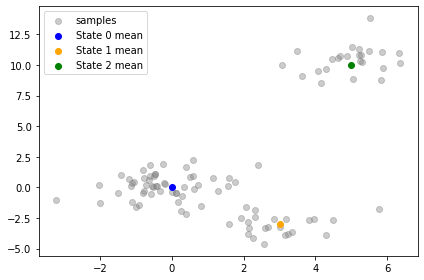

In [ ]:
colors = ['blue', 'orange', 'green', 'magenta']
plt.figure()
plt.scatter(X[:,0], X[:,1],alpha=0.4, color='gray',label='samples')
for ii in range(model.means_.shape[0]):
    plt.scatter(model.means_[ii,0], model.means_[ii,1] , 
                color=colors[ii], 
                label='State {0:d} mean'.format(ii))
plt.legend()
plt.tight_layout()


Dado que tenemos los valores de las variables latentes correspondientes a la generación de cada observación, podemos asignar un color a cada estado. También podemos representar la trayectoria seguida durante el proceso de generación de la secuencia.

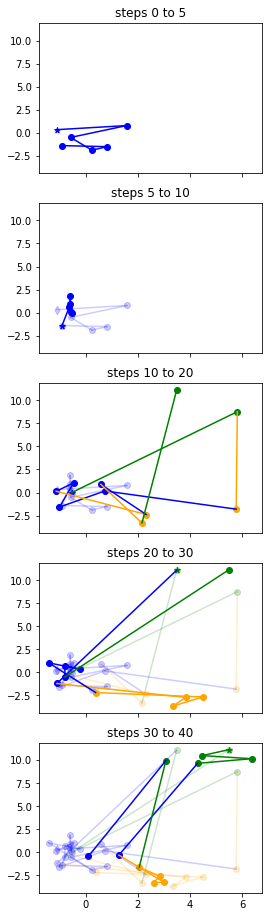

In [ ]:
nsteps = [5,10,20,30,40]
ff,aa = plt.subplots(5,1, figsize=(4,16), sharex=True, sharey=True)
for ii,ss in enumerate(nsteps):
    if ii > 0:
        jj = nsteps[ii-1]
        aa[ii].scatter(X[0,0], X[0,1], color=colors[Z[0]], alpha=0.2, marker='d')
        
    else:
        jj=0
        
    for n in range(1,jj+1):
        aa[ii].scatter(X[n,0], X[n,1], color=colors[Z[n]], alpha=0.2)
        aa[ii].plot([X[n-1,0], X[n,0]], 
                    [X[n-1,1], X[n,1]], 
                    color=colors[Z[n]], alpha=0.2)

    aa[ii].scatter(X[jj,0], X[jj,1], color=colors[Z[jj]], marker='*')
    for n in range(jj+1,ss+1):
        aa[ii].scatter(X[n,0], X[n,1], color=colors[Z[n]])
        aa[ii].plot([X[n-1,0], X[n,0]], [X[n-1,1], X[n,1]], color=colors[Z[n]])
    aa[ii].set_title("steps {0:d} to {1:d}".format(jj,ss))

Gráfica de todas las observaciones con su estado correspondiente

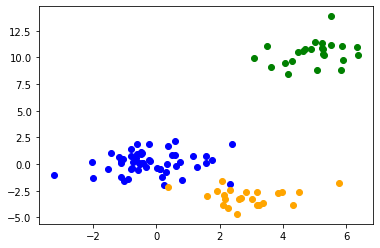

In [ ]:
plt.figure()

for ii in range(model.means_.shape[0]):
    plt.scatter(X[Z==ii,0], X[Z==ii,1] , 
                color=colors[ii], 
                label='State {0:d} data'.format(ii))

## 3.2.- Uso de `hmmlearn` para aprender los parámetros de un HMM a partir de una secuencia.

El módulo `hmmlearn` incluye un método `fit` para aprender los parámetros del modelo a partir de una secuencia o un grupo de secuencias.

Vamos a ver qué HMM aprenderíamos si empleamos la secuencia `X` generada antes

In [ ]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
remodel.fit(X)
Z2 = remodel.predict(X)

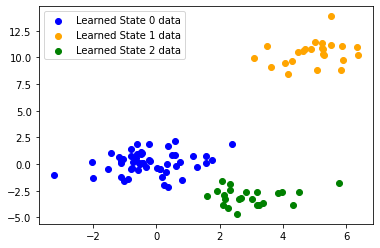

In [ ]:
plt.figure()

for ii in range(model.means_.shape[0]):
    plt.scatter(X[Z2==ii,0], X[Z2==ii,1] , 
                color=colors[ii], 
                label='Learned State {0:d} data'.format(ii))
plt.legend()

## 3.3. Evaluar la probabilidad de que una secuencia salga de un modelo

El módulo `hmmlearn` proporciona un método `score` que calcula el ajuste (en *log-probabilidad*) de una secuencia con un modelo. 

¿En qué modelo pensáis que `X` va a dar mejor `score` en el modelo con el que se creó `model` o en `remodel`? 

In [ ]:
print("Score con remodel {0:f}".format(remodel.score(X)))
print("Score con model {0:f}".format(model.score(X)))

      

Score con remodel -349.640523
Score con model -363.381132


Podemos inspeccionar los parámetros aprendidos y compararlos con los originales

In [ ]:
print("Probabilidades iniciales")
print("")
print("Creados")
print(model.startprob_)
print("")
print("Aprendidos")
print(remodel.startprob_)

Probabilidades iniciales
Creados
[0.6 0.3 0.1]

Aprendidos
[1.00000000e+000 2.48941256e-183 3.53281766e-055]


In [ ]:
print("Medias de los estados (pueden aparecer descolocadas)")
print("")
print("Creados")
print(model.means_)
print("")
print("Aprendidos")
print(remodel.means_)

Medias de los estados (pueden aparecer descolocadas)

Creados
[[ 0.  0.]
 [ 3. -3.]
 [ 5. 10.]]

Aprendidos
[[-0.24426782  0.12768295]
 [ 4.9594706  10.41581473]
 [ 2.91854222 -3.03503021]]


En general, si usamos un modelo para generar una secuencia,  esperamos que el ajuste de esa secuencia para ese modelo sea mejor que para cualquier otro modelo

In [ ]:
X3, Z3 = model.sample(Nsamples)

In [ ]:
model.score(X3)

-375.71505864149486

In [ ]:
remodel.score(X3)

-389.546703225587

# 4.- HMMs en series temporales de finanzas

En el siguiente ejemplo vamos a usar  HMMs para estudiar el comportamiento de series temporales de precios de valores. Comúnmente algunos analistas financieros explican el comportamiento de las series de precios con dos *estados*:

- **Bullish**: Los precios suben despacio. Cuando la economía va razonablemente bien, los inversores ganan confianza y compran acciones de valores que tienen expectativas de subir, para venderlos más caros en el futuro y ganar dinero en la inversión. Un aumento en el número de órdenes de compra hace que el precio de esos valores ascienda. Esta serie de pequeños movimientos hacia arriba recuerdan a un toro intentando alcanzar algo con sus cuernos, de ahí el nombre *bullish*.
- **Bearish**: Los precios caen súbitamente. Por ejemplo, en los momentos iniciales de una crisis los inversores se asustan ante la perspectiva de que el precio de sus acciones baje y deshacen sus posiciones sacando el capital del mercado, por ejemplo para acudir a valores refugio. Este aumento de órdenes de venta hace que los precios bajen. Si antes veíamos que los precios suelen subir despacio, las bajadas son rápidas y en general más profundas, el movimiento recuerda a un oso dando un zarpazo, de ahí el nombre *bearish* (aparentemente el brazo de un oso llega más lejos que el cuello de un toro...).

Vamos a analizar algunas series de precios con HMMs a ver si somos capaces de recuperar estos estados usando datos reales.

Comenzamos con la serie de precios del IBEX35. El csv que se carga en la celda de abajo contiene datos descargados [**Yahoo Finance**](https://es.finance.yahoo.com/), con la expresión "^IBEX" en la ventana de búsqueda.

### 4.1.- Leer el csv con pandas 

In [ ]:
data = pd.read_csv('IBEX_20200511.csv',parse_dates=["Date"], index_col='Date').dropna()

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-02-15,9834.599609,9913.400391,9764.099609,9865.299805,9865.290039,10256100.0
1993-03-19,9393.299805,9393.299805,9243.000000,9251.299805,9251.290039,6878000.0
1993-04-06,2612.300049,2612.300049,2599.300049,2603.199951,2603.197266,0.0
1993-04-07,2596.800049,2596.800049,2574.399902,2595.199951,2595.197266,0.0
1993-04-12,2595.199951,2603.500000,2580.800049,2601.399902,2601.397217,0.0


De todos los precios nos quedamos con el **cierre ajustado** `Adj Close`

<AxesSubplot:xlabel='Date'>

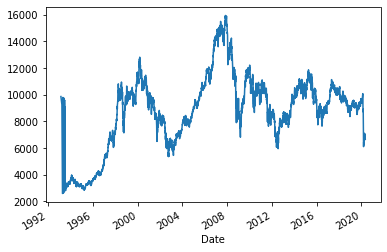

In [ ]:
plt.figure()
data['Adj Close'].plot()

Vamos a emplear datos desde Enero de 2002 porque es el comienzo del euro.

In [ ]:
data = data.loc[data.index.date>datetime.date(2002,1,1)]

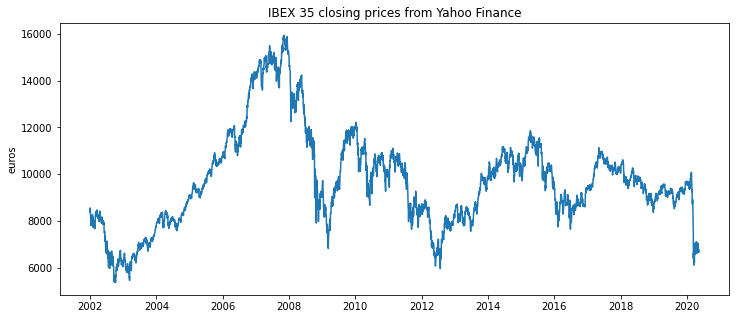

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data.index,data['Adj Close'].values)
plt.title('IBEX 35 closing prices from Yahoo Finance')
_=plt.ylabel('euros')

### 4.2.- Normalizamos los datos para comparar mismos efectos en instantes lejanos

Es conveniente normalizar los precios para poder comparar movimientos en precio durante un largo intervalo de tiempo en el que se dan las observaciones. En la gráfica de arriba podemos ver cómo hay periodos de tiempo en los que el índice se mueve en entornos de 6000-7000 euros mientras que en otros pasa ampliamente de 14000 euros. Un movimiento de precio de 6 euros en un entorno de 6000 euros de precio de índice (el precio se mueve un 0.1%) es mucho más significativo que en un entorno de 14000 euros (el precio se mueve un 0.04%).


Generalmente se emplea una de estas dos estrategias para conseguir una serie normalizada. 
- Estudiar la serie de diferencias logarítmicas de precios
$$
\Delta[t] = \log(S[t]) - \log(S[t-1])
$$
- Estudiar la serie de movimientos de precio relativos
$$
R[t] = \frac{S[t] - S[t-1]}{S[t-1]}10^4
$$

Esta segunda serie se conoce como **retorno en puntos básicos**.

Calculamos estas dos series para el IBEX35

In [ ]:
IBEX = data['Adj Close'].to_frame()
IBEX.columns=['price']
IBEX['tomorrow'] = IBEX['price'].shift(-1)
IBEX['delta_log_price'] = IBEX['tomorrow'].apply(np.log) - IBEX['price'].apply(np.log) 
IBEX['return_bps'] = (IBEX['tomorrow'] - IBEX['price']) / IBEX['price']*1e4

IBEX=IBEX.dropna()

In [ ]:
IBEX.head()

,price,tomorrow,delta_log_price,return_bps
Date,,,,
2002-01-02,8377.090820,8554.691406,0.020979,212.007473
2002-01-03,8554.691406,8463.090820,-0.010765,-107.076435
2002-01-04,8463.090820,8177.291504,-0.034353,-337.700873
2002-01-07,8177.291504,8186.591797,0.001137,11.373317
2002-01-08,8186.591797,8066.091797,-0.014829,-147.191900


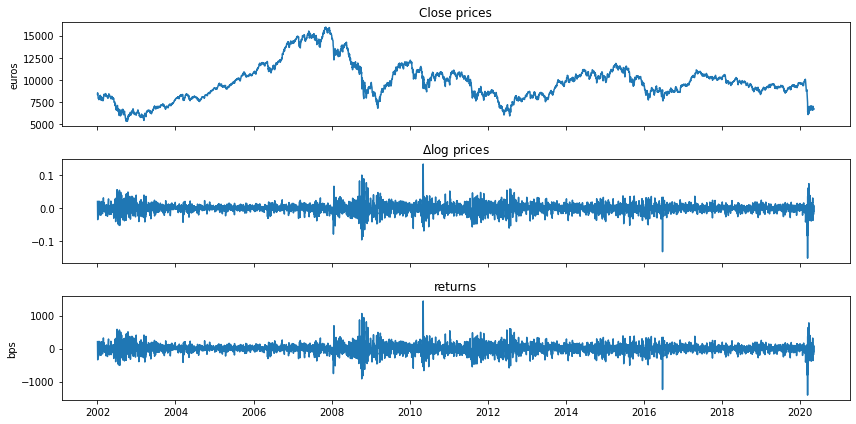

In [ ]:
ff,aa = plt.subplots(3,1,sharex=True,figsize=(12,6))
_=aa[0].plot(IBEX.index, IBEX['price'].values)
_=aa[0].set_ylabel('euros')
_=aa[0].set_title('Close prices')
aa[1].plot(IBEX.index, IBEX['delta_log_price'].values)
_=aa[1].set_title('$\\Delta$log prices')
aa[2].plot(IBEX.index, IBEX['return_bps'].values)
_=aa[2].set_title('returns')
_=aa[2].set_ylabel('bps')
ff.tight_layout()

### 4.3.- Aprender un HMM con la serie de precios normalizada

Usamos `hmmlearn` para aprender un modelo HMM con dos estados a ver si somos capaces de recuperar los dos estados *bearish* y  *bullish*  en la dinámica temporal del IBEX35.

In [ ]:
Nstates = 2
HMM_IBEX = hmm.GaussianHMM(n_components=Nstates, covariance_type="diag", n_iter=100)
HMM_IBEX.fit(IBEX['return_bps'].values.reshape(-1,1))
States_IBEX = HMM_IBEX.predict(IBEX['return_bps'].values.reshape(-1,1))

Examinamos la configuración de  estados aprendidos.

In [ ]:
for ss in range(Nstates):
    print("Estado {0:d}".format(ss))
    print("-----------------------------")
    print("Media: {0:.3f} bps".format(HMM_IBEX.means_[ss][0]))
    print("Desv típica: {0:.3f} bps".format(np.sqrt(HMM_IBEX.covars_[ss][0][0])))
    print("Probabilidad de permanencia: {0:.2f}".format(HMM_IBEX.transmat_[ss,ss]))
    print(" ")

Estado 0
-----------------------------
Media: -11.370 bps
Desv típica: 220.695 bps
Probabilidad de permanencia: 0.98
 
Estado 1
-----------------------------
Media: 6.320 bps
Desv típica: 88.308 bps
Probabilidad de permanencia: 0.99
 


Matriz de transiciones entre estados

In [ ]:
np.round(HMM_IBEX.transmat_,2)

array([[0.98, 0.02],
       [0.01, 0.99]])

Plots

In [ ]:
IBEX['State'] = States_IBEX

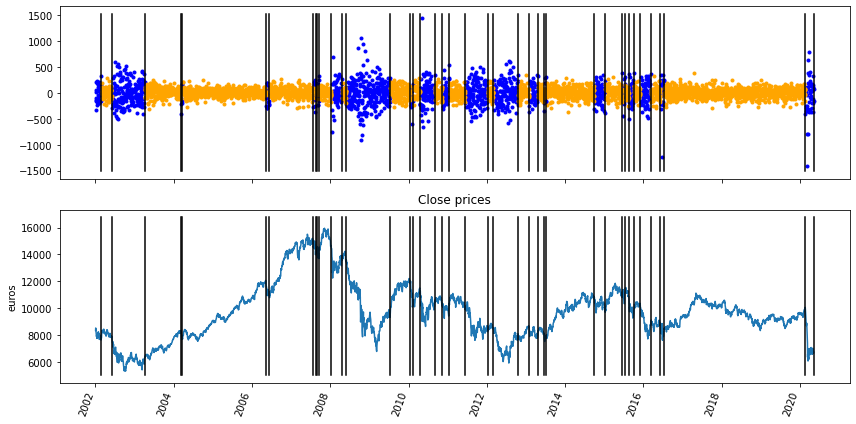

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(12,6),sharex=True)
for ii in range(3):
    aa[0].scatter(IBEX.loc[IBEX['State']==ii].index, 
         IBEX.loc[IBEX['State']==ii,'return_bps'].values, 
                marker='.',
         color=colors[ii],
         label='state {0:d}'.format(ii))
transitions = (IBEX['State'] - IBEX['State'].shift(-1)) != 0
transitions = transitions.loc[transitions==True]
ymax0 = np.max(np.absolute(IBEX['return_bps'].values))*1.05
ymax1 = np.max(np.absolute(IBEX['price'].values))*1.05
ymin1 = np.min(np.absolute(IBEX['price'].values))*.95
aa[1].plot(IBEX.index, IBEX['price'].values)
for tt in transitions.index:
    aa[0].plot([tt,tt],[-ymax0,ymax0],color='black')
    aa[1].plot([tt,tt],[ymin1,ymax1],color='black')

    
for label in aa[1].get_xticklabels():
    label.set_rotation(70)
    label.set_ha('right')


_=aa[1].set_ylabel('euros')
_=aa[1].set_title('Precios de cierre')

ff.tight_layout()

### 4.4. Repetimos el análisis con un número de estados distinto

In [ ]:
Nstates = 3
HMM_IBEX = hmm.GaussianHMM(n_components=Nstates, covariance_type="diag", n_iter=100)
HMM_IBEX.fit(IBEX['return_bps'].values.reshape(-1,1))
States_IBEX = HMM_IBEX.predict(IBEX['return_bps'].values.reshape(-1,1))
IBEX['State'] = States_IBEX

In [ ]:
for ss in range(Nstates):
    print("Estado {0:d}".format(ss))
    print("-----------------------------")
    print("Media: {0:.3f} bps".format(HMM_IBEX.means_[ss][0]))
    print("Desv típica:  {0:.3f} bps".format(np.sqrt(HMM_IBEX.covars_[ss][0][0])))
    print("Probabilidad de permanencia: {0:.2f}".format(HMM_IBEX.transmat_[ss,ss]))
    print(" ")

Estado 0
-----------------------------
Media: 8.981 bps
Desv típica:  74.960 bps
Probabilidad de permanencia: 0.98
 
Estado 1
-----------------------------
Media: -4.283 bps
Desv típica:  143.629 bps
Probabilidad de permanencia: 0.97
 
Estado 2
-----------------------------
Media: -18.189 bps
Desv típica:  303.917 bps
Probabilidad de permanencia: 0.96
 


Matriz de transiciones entre estados

In [ ]:
np.round(HMM_IBEX.transmat_,2)

array([[0.98, 0.02, 0.  ],
       [0.02, 0.97, 0.01],
       [0.  , 0.04, 0.96]])

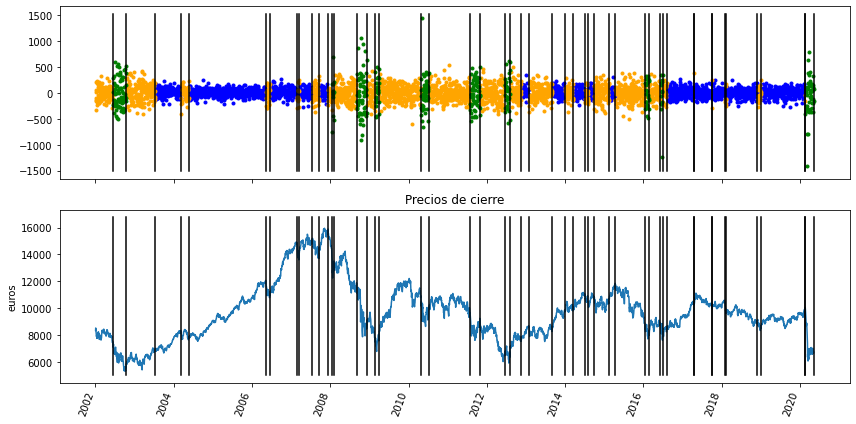

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(12,6),sharex=True)
for ii in range(Nstates):
    aa[0].scatter(IBEX.loc[IBEX['State']==ii].index, 
         IBEX.loc[IBEX['State']==ii,'return_bps'].values, 
                marker='.',
         color=colors[ii],
         label='state {0:d}'.format(ii))
transitions = (IBEX['State'] - IBEX['State'].shift(-1)) != 0
transitions = transitions.loc[transitions==True]
ymax0 = np.max(np.absolute(IBEX['return_bps'].values))*1.05
ymax1 = np.max(np.absolute(IBEX['price'].values))*1.05
ymin1 = np.min(np.absolute(IBEX['price'].values))*.95
aa[1].plot(IBEX.index, IBEX['price'].values)
for tt in transitions.index:
    aa[0].plot([tt,tt],[-ymax0,ymax0],color='black')
    aa[1].plot([tt,tt],[ymin1,ymax1],color='black')

    
for label in aa[1].get_xticklabels():
    label.set_rotation(70)
    label.set_ha('right')


_=aa[1].set_ylabel('euros')
_=aa[1].set_title('Precios de cierre')

ff.tight_layout()

### 4.5. Buscamos una historia que contar con los datos

Hacemos zoom para mirar el refrendum del Brexit (June 23, 2016)

In [ ]:
brexit_dates = IBEX.index[(IBEX.index.date > datetime.date(2016,6,15)) & (IBEX.index.date < datetime.date(2016,7,2))]

In [ ]:
IBEX.loc[brexit_dates]


,price,tomorrow,delta_log_price,return_bps,State
Date,,,,,
2016-06-16,8199.891602,8361.991211,0.019576,197.685063,2
2016-06-17,8361.991211,8647.090820,0.033526,340.947033,2
2016-06-20,8647.090820,8667.291016,0.002333,23.360684,2
2016-06-21,8667.291016,8701.991211,0.003996,40.035802,2
2016-06-22,8701.991211,8885.291016,0.020845,210.641221,2
2016-06-23,8885.291016,7787.700195,-0.131852,-1235.289670,2
2016-06-24,7787.700195,7645.500000,-0.018428,-182.595877,2
2016-06-27,7645.500000,7835.000000,0.024484,247.858217,2
2016-06-28,7835.000000,8105.299805,0.033917,344.990179,2


### 4.6. Exploramos un valor diferente

Podemos repetir el análisis para el CAC40.

In [ ]:
data = pd.read_csv('CAC40_20200512.csv',parse_dates=["Date"], index_col='Date').dropna()

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-01,1836.0,1838.0,1827.0,1832.0,1832.0,0.0
1990-03-02,1831.0,1860.0,1831.0,1860.0,1860.0,0.0
1990-03-05,1866.0,1874.0,1862.0,1874.0,1874.0,0.0
1990-03-06,1869.0,1875.0,1866.0,1872.0,1872.0,0.0
1990-03-07,1874.0,1881.0,1874.0,1880.0,1880.0,0.0


In [ ]:
data = data.loc[data.index.date>datetime.date(2002,1,1)]

In [ ]:
data = pd.read_csv('CAC40_20200512.csv',parse_dates=["Date"], index_col='Date').dropna()
data = data.loc[data.index.date>datetime.date(2002,1,1)]
CAC = data['Adj Close'].to_frame()
CAC.columns=['price']
CAC['tomorrow'] = CAC['price'].shift(-1)
CAC['delta_log_price'] = CAC['tomorrow'].apply(np.log) - CAC['price'].apply(np.log) 
CAC['return_bps'] = (CAC['tomorrow'] - CAC['price']) / CAC['price']*1e4

CAC=CAC.dropna()

In [ ]:
data = pd.read_csv('CAC40_20200512.csv',parse_dates=["Date"], index_col='Date').dropna()
data = data.loc[data.index.date>datetime.date(2002,1,1)]
CAC = data['Adj Close'].to_frame()
CAC.columns=['price']
CAC['tomorrow'] = CAC['price'].shift(-1)
CAC['delta_log_price'] = CAC['tomorrow'].apply(np.log) - CAC['price'].apply(np.log) 
CAC['return_bps'] = (CAC['tomorrow'] - CAC['price']) / CAC['price']*1e4

CAC=CAC.dropna()
Nstates = 3
HMM_CAC = hmm.GaussianHMM(n_components=Nstates, covariance_type="diag", n_iter=100)
HMM_CAC.fit(CAC['return_bps'].values.reshape(-1,1))
States_CAC = HMM_CAC.predict(CAC['return_bps'].values.reshape(-1,1))
CAC['State'] = States_CAC

ESTADOS CAC40
Estado 0
-----------------------------
Media: -21.056 bps
Desv típica:  303.144 bps
Probabilidad de permanencia: 0.98
 
Estado 1
-----------------------------
Media: -3.128 bps
Desv típica:  135.885 bps
Probabilidad de permanencia: 0.97
 
Estado 2
-----------------------------
Media: 10.577 bps
Desv típica:  67.435 bps
Probabilidad de permanencia: 0.97
 
Matriz de transiciones entre estados
[[0.98 0.02 0.  ]
 [0.01 0.97 0.03]
 [0.   0.03 0.97]]


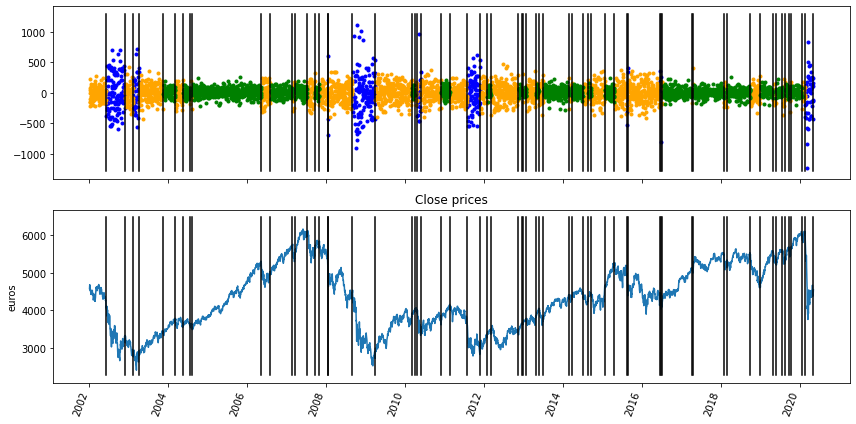

In [ ]:
data = pd.read_csv('CAC40_20200512.csv',parse_dates=["Date"], index_col='Date').dropna()
data = data.loc[data.index.date>datetime.date(2002,1,1)]
CAC = data['Adj Close'].to_frame()
CAC.columns=['price']
CAC['tomorrow'] = CAC['price'].shift(-1)
CAC['delta_log_price'] = CAC['tomorrow'].apply(np.log) - CAC['price'].apply(np.log) 
CAC['return_bps'] = (CAC['tomorrow'] - CAC['price']) / CAC['price']*1e4

CAC=CAC.dropna()
Nstates = 3
HMM_CAC = hmm.GaussianHMM(n_components=Nstates, covariance_type="diag", n_iter=100)
HMM_CAC.fit(CAC['return_bps'].values.reshape(-1,1))

print("ESTADOS CAC40")
for ss in range(Nstates):
    print("Estado {0:d}".format(ss))
    print("-----------------------------")
    print("Media: {0:.3f} bps".format(HMM_CAC.means_[ss][0]))
    print("Desv típica:  {0:.3f} bps".format(np.sqrt(HMM_CAC.covars_[ss][0][0])))
    print("Probabilidad de permanencia: {0:.2f}".format(HMM_CAC.transmat_[ss,ss]))
    print(" ")
print("Matriz de transiciones entre estados")
print(np.round(HMM_CAC.transmat_,2))


States_CAC = HMM_CAC.predict(CAC['return_bps'].values.reshape(-1,1))
CAC['State'] = States_CAC
ff,aa = plt.subplots(2,1,figsize=(12,6),sharex=True)
for ii in range(Nstates):
    aa[0].scatter(CAC.loc[CAC['State']==ii].index, 
         CAC.loc[CAC['State']==ii,'return_bps'].values, 
                marker='.',
         color=colors[ii],
         label='state {0:d}'.format(ii))
transitions = (CAC['State'] - CAC['State'].shift(-1)) != 0
transitions = transitions.loc[transitions==True]
ymax0 = np.max(np.absolute(CAC['return_bps'].values))*1.05
ymax1 = np.max(np.absolute(CAC['price'].values))*1.05
ymin1 = np.min(np.absolute(CAC['price'].values))*.95
aa[1].plot(CAC.index, CAC['price'].values)
for tt in transitions.index:
    aa[0].plot([tt,tt],[-ymax0,ymax0],color='black')
    aa[1].plot([tt,tt],[ymin1,ymax1],color='black')

    
for label in aa[1].get_xticklabels():
    label.set_rotation(70)
    label.set_ha('right')


_=aa[1].set_ylabel('euros')
_=aa[1].set_title('Close prices')

ff.tight_layout()

Repetimos las curvas del IBEX para comparar...

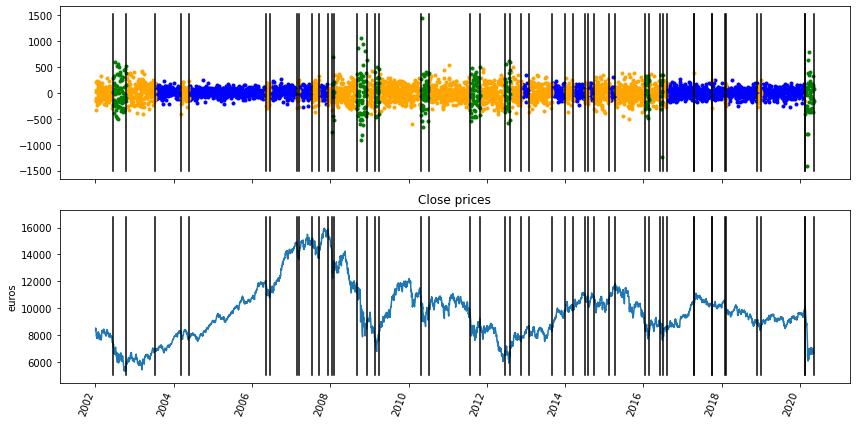

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(12,6),sharex=True)
for ii in range(Nstates):
    aa[0].scatter(IBEX.loc[IBEX['State']==ii].index, 
         IBEX.loc[IBEX['State']==ii,'return_bps'].values, 
                marker='.',
         color=colors[ii],
         label='state {0:d}'.format(ii))
transitions = (IBEX['State'] - IBEX['State'].shift(-1)) != 0
transitions = transitions.loc[transitions==True]
ymax0 = np.max(np.absolute(IBEX['return_bps'].values))*1.05
ymax1 = np.max(np.absolute(IBEX['price'].values))*1.05
ymin1 = np.min(np.absolute(IBEX['price'].values))*.95
aa[1].plot(IBEX.index, IBEX['price'].values)
for tt in transitions.index:
    aa[0].plot([tt,tt],[-ymax0,ymax0],color='black')
    aa[1].plot([tt,tt],[ymin1,ymax1],color='black')

    
for label in aa[1].get_xticklabels():
    label.set_rotation(70)
    label.set_ha('right')


_=aa[1].set_ylabel('euros')
_=aa[1].set_title('Close prices')

ff.tight_layout()

Y con el NASDAQ

ESTADOS NASDAQ
Estado 0
-----------------------------
Media: 13.262 bps
Desv típica:  72.541 bps
Probabilidad de permanencia: 0.98
 
Estado 1
-----------------------------
Media: -5.231 bps
Desv típica:  145.230 bps
Probabilidad de permanencia: 0.97
 
Estado 2
-----------------------------
Media: -9.807 bps
Desv típica:  330.210 bps
Probabilidad de permanencia: 0.97
 
Matriz de transiciones entre estados
[[0.98 0.02 0.  ]
 [0.02 0.97 0.  ]
 [0.   0.03 0.97]]


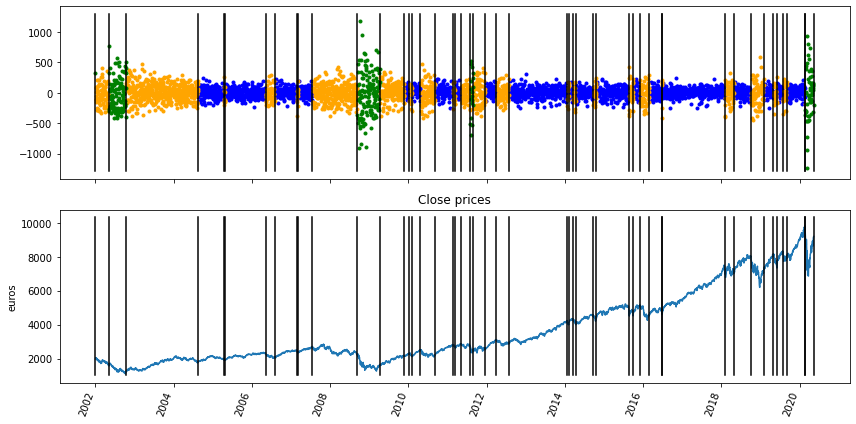

In [ ]:
data = pd.read_csv('NASDAQ_20200512.csv',parse_dates=["Date"], index_col='Date').dropna()
data = data.loc[data.index.date>datetime.date(2002,1,1)]
CAC = data['Adj Close'].to_frame()
CAC.columns=['price']
CAC['tomorrow'] = CAC['price'].shift(-1)
CAC['delta_log_price'] = CAC['tomorrow'].apply(np.log) - CAC['price'].apply(np.log) 
CAC['return_bps'] = (CAC['tomorrow'] - CAC['price']) / CAC['price']*1e4

CAC=CAC.dropna()
Nstates = 3
HMM_CAC = hmm.GaussianHMM(n_components=Nstates, covariance_type="diag", n_iter=100)
HMM_CAC.fit(CAC['return_bps'].values.reshape(-1,1))

print("ESTADOS NASDAQ")
for ss in range(Nstates):
    print("Estado {0:d}".format(ss))
    print("-----------------------------")
    print("Media: {0:.3f} bps".format(HMM_CAC.means_[ss][0]))
    print("Desv típica:  {0:.3f} bps".format(np.sqrt(HMM_CAC.covars_[ss][0][0])))
    print("Probabilidad de permanencia: {0:.2f}".format(HMM_CAC.transmat_[ss,ss]))
    print(" ")
print("Matriz de transiciones entre estados")
print(np.round(HMM_CAC.transmat_,2))


States_CAC = HMM_CAC.predict(CAC['return_bps'].values.reshape(-1,1))
CAC['State'] = States_CAC
ff,aa = plt.subplots(2,1,figsize=(12,6),sharex=True)
for ii in range(Nstates):
    aa[0].scatter(CAC.loc[CAC['State']==ii].index, 
         CAC.loc[CAC['State']==ii,'return_bps'].values, 
                marker='.',
         color=colors[ii],
         label='state {0:d}'.format(ii))
transitions = (CAC['State'] - CAC['State'].shift(-1)) != 0
transitions = transitions.loc[transitions==True]
ymax0 = np.max(np.absolute(CAC['return_bps'].values))*1.05
ymax1 = np.max(np.absolute(CAC['price'].values))*1.05
ymin1 = np.min(np.absolute(CAC['price'].values))*.95
aa[1].plot(CAC.index, CAC['price'].values)
for tt in transitions.index:
    aa[0].plot([tt,tt],[-ymax0,ymax0],color='black')
    aa[1].plot([tt,tt],[ymin1,ymax1],color='black')

    
for label in aa[1].get_xticklabels():
    label.set_rotation(70)
    label.set_ha('right')


_=aa[1].set_ylabel('euros')
_=aa[1].set_title('Close prices')

ff.tight_layout()